In [3]:
# !pip install opendatasets
import opendatasets as od
import pandas

od.download(
	"https://www.kaggle.com/datasets/jessicali9530/lfw-dataset")

Skipping, found downloaded files in "./lfw-dataset" (use force=True to force download)


In [4]:
# !pip install opencv-python
# !pip install face_recognition
# general functions
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import OrderedDict
# visualization
from PIL import Image
# identifying faces
# !pip install mtcnn
from mtcnn.mtcnn import MTCNN
# visualizing bounding boxes
import matplotlib.patches as patches
# CNN
import keras
from sklearn.model_selection import train_test_split
# Moving files between directories
import shutil
from shutil import unpack_archive
from subprocess import check_output

# import deeplake
# ds = deeplake.load(r"C:\Users\ASUS\Downloads\archive (6)\lfw-deepfunneled")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 29.6 MB/s eta 0:00:00


In [6]:
lfw_allnames = pd.read_csv("/content/lfw-dataset/lfw_allnames.csv")
matchpairsDevTest = pd.read_csv("/content/lfw-dataset/matchpairsDevTest.csv")
matchpairsDevTrain = pd.read_csv("/content/lfw-dataset/matchpairsDevTrain.csv")
mismatchpairsDevTest = pd.read_csv("/content/lfw-dataset/mismatchpairsDevTest.csv")
mismatchpairsDevTrain = pd.read_csv("/content/lfw-dataset/mismatchpairsDevTrain.csv")
pairs = pd.read_csv("/content/lfw-dataset/pairs.csv")
# tidy pairs data:
pairs = pairs.rename(columns ={'name': 'name1', 'Unnamed: 3': 'name2'})
matched_pairs = pairs[pairs["name2"].isnull()].drop("name2",axis=1)
mismatched_pairs = pairs[pairs["name2"].notnull()]
people = pd.read_csv("/content/lfw-dataset/people.csv")
# remove null values
people = people[people.name.notnull()]
peopleDevTest = pd.read_csv("/content/lfw-dataset/peopleDevTest.csv")
peopleDevTrain = pd.read_csv("/content/lfw-dataset/peopleDevTrain.csv")

In [7]:
# shape data frame so there is a row per image, matched to relevant jpg file
image_paths = lfw_allnames.loc[lfw_allnames.index.repeat(lfw_allnames['images'])]
image_paths['image_path'] = 1 + image_paths.groupby('name').cumcount()
image_paths['image_path'] = image_paths.image_path.apply(lambda x: '{0:0>4}'.format(x))
image_paths['image_path'] = image_paths.name + "/" + image_paths.name + "_" + image_paths.image_path + ".jpg"
image_paths = image_paths.drop("images", axis = 1)

# take a random sample: 80% of the data for the train set
lfw_train, lfw_test = train_test_split(image_paths, test_size=0.2)
lfw_train = lfw_train.reset_index().drop("index",axis = 1)
lfw_test = lfw_test.reset_index().drop("index",axis = 1)

# verify that there is a mix of seen and unseen individuals in the test set
print(len(set(lfw_train.name).intersection(set(lfw_test.name))))
print(len(set(lfw_test.name) - set(lfw_train.name)))

# both comprehensively non-empty - we are ok to procede.
# N.B. although we don't use this training/test split in the following model, this is the format of the data we
# would use in applying models to the full dataset

849
873


In [8]:
# verify resolution of all images is consistent
widths = []
heights = []
files = image_paths.image_path
base_path = r"/content/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled" # define base path

for file in files:
    path = os.path.join(base_path, file) # join base path and relative path
    #path = "C:\\Users\\ASUS\\Downloads\\archive (6)\\lfw-deepfunneled\\lfw-deepfunneled\\AJ_Cook" + str(file) # old line
    im = Image.open(path)
    widths.append(im.width)
    heights.append(im.height)

pd.DataFrame({'height':heights,'width':widths}).describe()

# all 250 x 250 resolution

,height,width
count,13233.0,13233.0
mean,250.0,250.0
std,0.0,0.0
min,250.0,250.0
25%,250.0,250.0
50%,250.0,250.0
75%,250.0,250.0
max,250.0,250.0


<Axes: xlabel='name'>

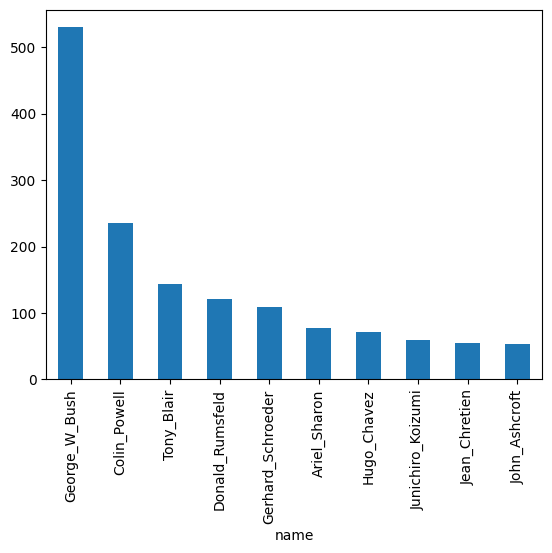

In [9]:
image_paths['name'].value_counts()[:10].plot(kind = "bar")

In [10]:
ind_counts = image_paths.groupby('name').count().image_path
print(str(sum(ind_counts[ind_counts==1])) + " individuals, which is " + str(round(100*(sum(ind_counts[ind_counts==1])/sum(ind_counts)))) + "% of the total individuals considered, are only represented by a single image in this dataset.")

4069 individuals, which is 31% of the total individuals considered, are only represented by a single image in this dataset.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


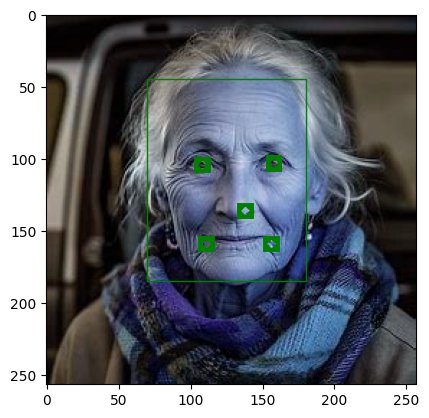

In [27]:
# Use out-of-the-box MTCNN algorithm to identify facial boundaries on a sample image
detector = MTCNN()
image = cv2.imread("/content/download.jpeg")
result = detector.detect_faces(image)
# That's it - the results have already been generated! Now we extract the boundaries that have been identified
bounding_box = result[0]['box']
keypoints = result[0]['keypoints']

# Finally, we plot the image along with the face's bounding box and internal features (eyes, nose, and mouth corners)
fig,ax = plt.subplots(1)
ax.imshow(image)
# Create a Rectangle patch
rect = patches.Rectangle(bounding_box[0:2],bounding_box[2],bounding_box[3],linewidth=1,edgecolor='g',facecolor='none')
# Add the patch to the Axes
ax.add_patch(rect)
# Visualize all the internal features
for key in keypoints:
    rect_key = patches.Rectangle(keypoints[key],2,2,linewidth=10,edgecolor='g',facecolor='none')
    ax.add_patch(rect_key)
# Show the plots
plt.show()